# Jaffle Shop Data Analysis - Final Project

## Instructions
You have been hired as a data analyst for Jaffle Shop, a growing chain of gourmet toasted sandwich restaurants. The executive team needs insights to make strategic business decisions.

Using the provided datasets and Python Polars, analyze the business performance and provide data-driven recommendations. You must use Polars for all data manipulation and analysis.

## Available Data
- `Customers.csv`: Customer information
- `Orders.csv`: Order transactions with totals and timestamps
- `Items.csv`: Individual items within each order
- `Products.csv`: Product catalog with prices and descriptions
- `Stores.csv`: Store locations and opening dates
- `Supplies.csv`: Supply costs for each product

**Time Limit: 90 minutes**

## Setup and Data Loading

In [1]:
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#Importing the data

supplies1 = "https://raw.githubusercontent.com/allenhail/data-programming-final-proj/main/Supplies.csv"
orders1 = "https://raw.githubusercontent.com/allenhail/data-programming-final-proj/main/Orders.csv"
items1 = "https://raw.githubusercontent.com/allenhail/data-programming-final-proj/main/Items.csv"
products1 = "https://raw.githubusercontent.com/allenhail/data-programming-final-proj/main/Products.csv"
stores1 = "https://raw.githubusercontent.com/allenhail/data-programming-final-proj/main/Stores.csv"
customers1 = "https://raw.githubusercontent.com/allenhail/data-programming-final-proj/main/Customers.csv"

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Load all datasets
customers = pl.read_csv(customers1)
orders = pl.read_csv(orders1)
items = pl.read_csv(items1)
products = pl.read_csv(products1)
stores = pl.read_csv(stores1)
supplies = pl.read_csv(supplies1)

# Display basic information about each dataset
print("Dataset shapes:")
print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Items: {items.shape}")
print(f"Products: {products.shape}")
print(f"Stores: {stores.shape}")
print(f"Supplies: {supplies.shape}")

Dataset shapes:
Customers: (932, 2)
Orders: (63148, 7)
Items: (90184, 3)
Products: (10, 5)
Stores: (6, 4)
Supplies: (65, 5)


## Question 1: Revenue Performance Analysis

The CFO wants to understand the company's financial performance across different dimensions. Analyze:
- What is the total revenue generated by Jaffle Shop? (Store result in variable: `total_revenue`)
- How does revenue vary by store location? (Store result in variable: `revenue_by_store`)
- What are the monthly revenue trends? (Store result in variable: `monthly_revenue_trends`)
- Which day of the week generates the most revenue? (Store result in variable: `revenue_by_day_of_week`)
- Include at least one chart for one of these questions

In [3]:
# Q1.1: Calculate total revenue

total_revenue = orders.select(pl.sum("order_total"))[0,0]
print(f"The total revenue is: ${total_revenue:,.2f}")


The total revenue is: $66,038,193.00


In [4]:
# Q1.2: Revenue by store location (with store names)

# Join orders and stores dataframes on store_id and id respectively
revenue_by_store = orders.join(stores, left_on="store_id", right_on="id").with_columns(
    pl.col("name").alias("store_name")
)
# Group by store name and sum the order total
revenue_by_store = revenue_by_store.group_by("store_name").agg(pl.sum("order_total").alias("total_revenue"))

print("Revenue by store location:")
print(revenue_by_store)

Revenue by store location:
shape: (2, 2)
┌──────────────┬───────────────┐
│ store_name   ┆ total_revenue │
│ ---          ┆ ---           │
│ str          ┆ i64           │
╞══════════════╪═══════════════╡
│ Philadelphia ┆ 43215565      │
│ Brooklyn     ┆ 22822628      │
└──────────────┴───────────────┘


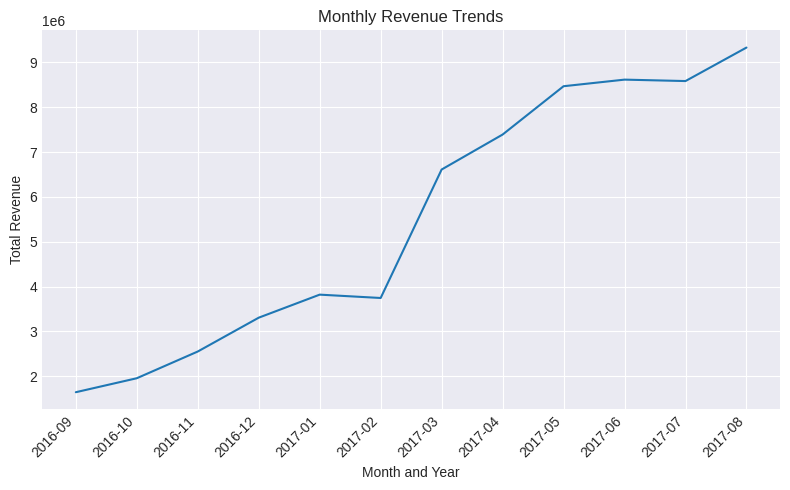

In [5]:
# Q1.3: Monthly revenue trends

monthly_revenue_trends = orders.with_columns(
    pl.col("ordered_at").str.strptime(pl.Datetime, strict=False).cast(pl.Date).alias("order_date")
).group_by(
    pl.col("order_date").dt.strftime("%Y-%m").alias("month_year")
).agg(pl.sum("order_total").alias("monthly_total")).sort("month_year")

plt.figure(figsize=(8, 5))
plt.plot(monthly_revenue_trends["month_year"], monthly_revenue_trends["monthly_total"])
plt.xlabel("Month and Year")
plt.ylabel("Total Revenue")
plt.title("Monthly Revenue Trends")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


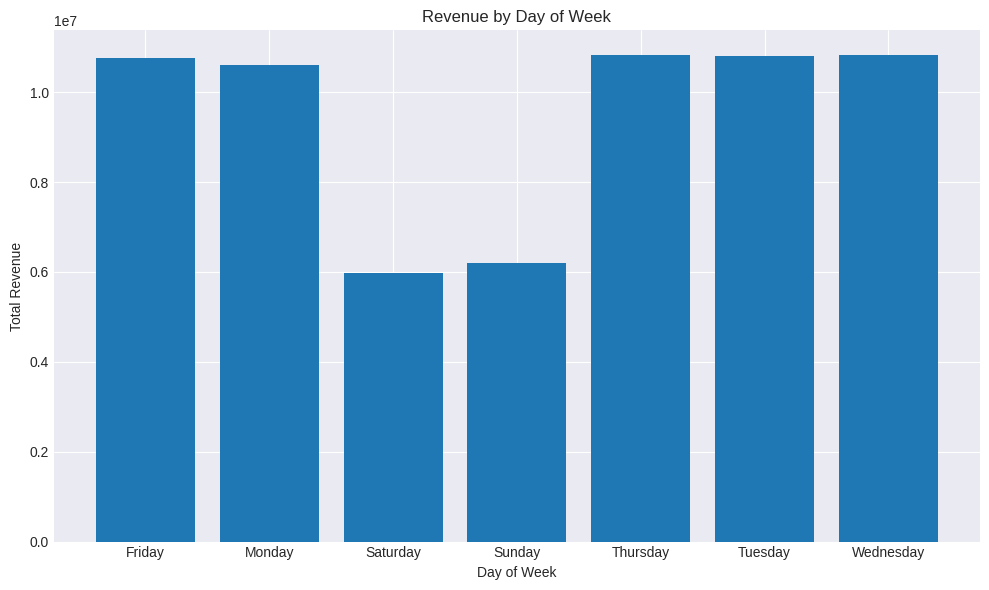

In [6]:
# Q1.4: Revenue by day of week

revenue_by_day_of_week = orders.with_columns(
    pl.col("ordered_at").str.strptime(pl.Datetime, strict=False).cast(pl.Date).dt.strftime("%A").alias("day_of_week")
).group_by("day_of_week").agg(pl.sum("order_total").alias("daily_total")).sort("day_of_week")

plt.figure(figsize=(10, 6))
plt.bar(revenue_by_day_of_week["day_of_week"], revenue_by_day_of_week["daily_total"])
plt.xlabel("Day of Week")
plt.ylabel("Total Revenue")
plt.title("Revenue by Day of Week")
plt.tight_layout()
plt.show()


## Question 2: Product Performance

The Product Manager needs insights about the menu items:
- What is the revenue contribution of each product category (jaffles vs beverages)? (Store result in variable: `revenue_by_category`)
- What is the average price of products by type (jaffles vs beverages)?
- Include at least one chart to answer one of the above questions.

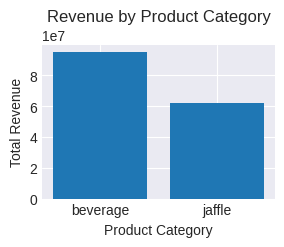

In [7]:
# Q2.1: Revenue by product category
# Your code here

order_items = orders.join(items, left_on="id", right_on="order_id")
order_items_products = order_items.join(products.select(["sku", "type"]), left_on="sku", right_on="sku")

revenue_by_category = order_items_products.group_by("type").agg(
    pl.sum("order_total").alias("category_total")
)

plt.figure(figsize=(3, 2))
plt.bar(revenue_by_category["type"], revenue_by_category["category_total"])
plt.xlabel("Product Category")
plt.ylabel("Total Revenue")
plt.title("Revenue by Product Category")
plt.show()


In [8]:
# Q2.2 Average price of products by type

average_price_by_type = products.group_by("type").agg(
    pl.mean("price").alias("average_price")
)
print(average_price_by_type)

shape: (2, 2)
┌──────────┬───────────────┐
│ type     ┆ average_price │
│ ---      ┆ ---           │
│ str      ┆ f64           │
╞══════════╪═══════════════╡
│ beverage ┆ 560.0         │
│ jaffle   ┆ 1200.0        │
└──────────┴───────────────┘


## Question 3: Store Expansion Strategy

The Operations Director is planning expansion strategies:
- Which stores have the highest revenue per day since opening? (Store result in variable: `revenue_per_day_by_store`)
- What is the relationship between local tax rates and store performance? (Store result in variable: `tax_rate_performance`)
- Include at least one chart to answer one of the above questions.

In [9]:
# Q3.1: Revenue per day since opening by store

# Convert ordered_at and opened_at to datetime objects
orders = orders.with_columns(pl.col("ordered_at").str.strptime(pl.Datetime, strict=False).alias("ordered_at_dt"))
stores = stores.with_columns(pl.col("opened_at").str.strptime(pl.Datetime, strict=False).alias("opened_at_dt"))

# Join orders and stores dataframes
orders_with_store_dates = orders.join(stores.select(["id", "opened_at_dt", "name"]), left_on="store_id", right_on="id")

# Calculate the number of days since opening for each order
orders_with_store_dates = orders_with_store_dates.with_columns(
    ((pl.col("ordered_at_dt") - pl.col("opened_at_dt")).dt.total_days()).alias("days_since_opening")
)

# Calculate total revenue and total operating days per store
store_revenue_days = orders_with_store_dates.group_by("name").agg([
    pl.sum("order_total").alias("total_revenue"),
    pl.max("days_since_opening").alias("total_operating_days")
])

# Calculate revenue per day since opening
revenue_per_day_by_store = store_revenue_days.with_columns(
    (pl.col("total_revenue") / (pl.col("total_operating_days") + 1)).alias("revenue_per_day") # Add 1 to avoid division by zero for the first day
).sort("revenue_per_day", descending=True)

print("Revenue per day since opening by store:")
print(revenue_per_day_by_store)

Revenue per day since opening by store:
shape: (2, 4)
┌──────────────┬───────────────┬──────────────────────┬─────────────────┐
│ name         ┆ total_revenue ┆ total_operating_days ┆ revenue_per_day │
│ ---          ┆ ---           ┆ ---                  ┆ ---             │
│ str          ┆ i64           ┆ i64                  ┆ f64             │
╞══════════════╪═══════════════╪══════════════════════╪═════════════════╡
│ Brooklyn     ┆ 22822628      ┆ 172                  ┆ 131922.705202   │
│ Philadelphia ┆ 43215565      ┆ 364                  ┆ 118398.808219   │
└──────────────┴───────────────┴──────────────────────┴─────────────────┘


Relationship between tax rate and store performance:
shape: (6, 5)
┌───────────────┬──────────┬───────────────┬──────────────────────┬─────────────────┐
│ name          ┆ tax_rate ┆ total_revenue ┆ total_operating_days ┆ revenue_per_day │
│ ---           ┆ ---      ┆ ---           ┆ ---                  ┆ ---             │
│ str           ┆ f64      ┆ i64           ┆ i64                  ┆ f64             │
╞═══════════════╪══════════╪═══════════════╪══════════════════════╪═════════════════╡
│ Philadelphia  ┆ 0.06     ┆ 43215565      ┆ 364                  ┆ 118398.808219   │
│ Brooklyn      ┆ 0.04     ┆ 22822628      ┆ 172                  ┆ 131922.705202   │
│ Chicago       ┆ 0.0625   ┆ null          ┆ null                 ┆ null            │
│ San Francisco ┆ 0.075    ┆ null          ┆ null                 ┆ null            │
│ New Orleans   ┆ 0.04     ┆ null          ┆ null                 ┆ null            │
│ Los Angeles   ┆ 0.08     ┆ null          ┆ null                 ┆ null 

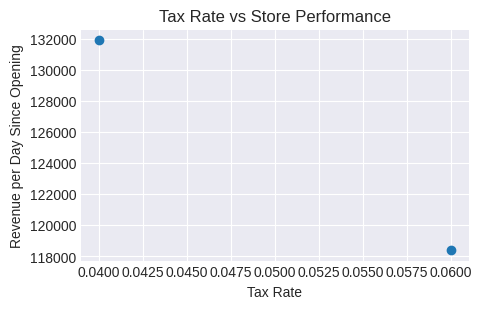

In [10]:
# Q3.2: Tax rates vs store performance

# Join the revenue per day data with store tax rates
tax_rate_performance = stores.select(["name", "tax_rate"]).join(revenue_per_day_by_store, on="name", how="left")

print("Relationship between tax rate and store performance:")
print(tax_rate_performance)

# Visualize the relationship
plt.figure(figsize=(5, 3))
plt.scatter(tax_rate_performance["tax_rate"], tax_rate_performance["revenue_per_day"])
plt.xlabel("Tax Rate")
plt.ylabel("Revenue per Day Since Opening")
plt.title("Tax Rate vs Store Performance")
plt.show()

## Question 4: Customer Behavior Analysis

The Marketing Manager wants to understand customer patterns:
- What is the distribution of order values? (Store result in variable: `order_value_distribution`)
- How many customers are repeat customers? (Store result in variable: `repeat_customer_analysis`)
- Which customers contribute the most to revenue? (Store result in variable: `top_revenue_customers`)

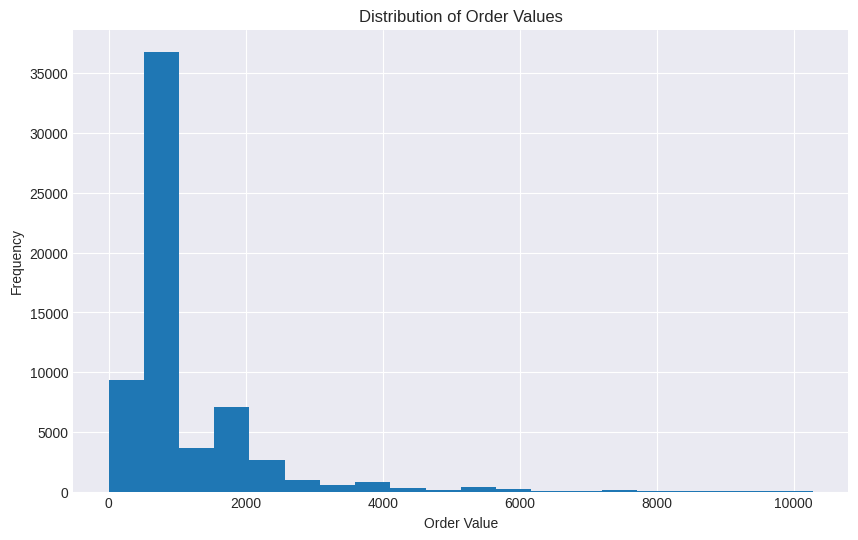

In [11]:
# Q4.1: Distribution of order values

order_value_distribution = orders.select("order_total")

plt.figure(figsize=(10, 6))
plt.hist(order_value_distribution["order_total"], bins=20)
plt.xlabel("Order Value")
plt.ylabel("Frequency")
plt.title("Distribution of Order Values")
plt.show()

In [12]:
# Q4.2: Repeat customers analysis

customer_order_counts = orders.group_by("customer").agg(pl.len().alias("number_of_orders"))
repeat_customers = customer_order_counts.filter(pl.col("number_of_orders") > 1)

total_unique_customers = customer_order_counts.shape[0]
num_repeat_customers = repeat_customers.shape[0]

print(f"Total unique customers: {total_unique_customers}")
print(f"Number of repeat customers: {num_repeat_customers}")
print(f"Percentage of repeat customers: {(num_repeat_customers / total_unique_customers) * 100:.2f}%")

Total unique customers: 930
Number of repeat customers: 920
Percentage of repeat customers: 98.92%


In [13]:
# Q4.3 Join customer_revenue with customers to get customer names


customer_revenue = (
    orders
    .group_by("customer")
    .agg(pl.sum("order_total").alias("total_revenue"))
)


top_revenue_people = (
    customer_revenue
    .sort("total_revenue", descending=True)
)

top_revenue_customers = (
    top_revenue_people
    .join(customers, left_on="customer", right_on="id")
    .select(["name", "total_revenue"])
    .sort("total_revenue", descending=True)
    .head(10)
)

print("Top 10 revenue contributing customers (with names, highest to lowest):")
print(top_revenue_customers)



Top 10 revenue contributing customers (with names, highest to lowest):
shape: (10, 2)
┌──────────────────────┬───────────────┐
│ name                 ┆ total_revenue │
│ ---                  ┆ ---           │
│ str                  ┆ i64           │
╞══════════════════════╪═══════════════╡
│ David Leonard        ┆ 262647        │
│ Jesse Moore          ┆ 259037        │
│ Diane Davis          ┆ 258515        │
│ Holly Johnson        ┆ 252703        │
│ Gregory Hayes        ┆ 249821        │
│ Julie Robinson       ┆ 247510        │
│ Christopher Robinson ┆ 246325        │
│ Douglas Burgess      ┆ 244102        │
│ Jacob Brown          ┆ 239641        │
│ Jenny Harrell        ┆ 237098        │
└──────────────────────┴───────────────┘


## Question 5: Profitability Deep Dive

The CEO needs a comprehensive profitability analysis:
- Calculate the gross margin for each product (consider supply costs) (Store result in variable: `product_margins`)
- Which products have the highest profit margins? (Store result in variable: `highest_margin_products`)
- What is the relationship between order size and profitability? (Store result in variable: `order_size_profitability`)
- How does profitability vary across different stores? (Store result in variable: `store_profitability`)

In [14]:
# Q5.1: Calculate gross margin per product
# Your code here

import polars as pl

# Calculate unit cost for each product from supplies data
# We need to sum up the cost of all supplies needed for each product SKU
sku_costs = supplies.group_by("sku").agg(pl.sum("cost").alias("unit_cost_cents"))

# Convert costs to USD (assuming costs are in cents)
sku_costs = sku_costs.with_columns(
    (pl.col("unit_cost_cents") / 100).alias("unit_cost_usd")
)

# Join product prices with supply costs
product_margins = products.join(sku_costs, on="sku")

# Calculate unit margin and margin percentage
product_margins = product_margins.with_columns([
    (pl.col("price") / 100).alias("price_usd"), # Convert price to USD
    (pl.col("price") / 100 - pl.col("unit_cost_usd")).alias("unit_margin_usd")
])

product_margins = product_margins.with_columns(
    (pl.col("unit_margin_usd") / pl.col("price_usd")).alias("margin_pct")
)

print("Gross margin per product:")
print(product_margins)

Gross margin per product:
shape: (10, 10)
┌─────────┬─────────────┬──────────┬───────┬───┬─────────────┬───────────┬────────────┬────────────┐
│ sku     ┆ name        ┆ type     ┆ price ┆ … ┆ unit_cost_u ┆ price_usd ┆ unit_margi ┆ margin_pct │
│ ---     ┆ ---         ┆ ---      ┆ ---   ┆   ┆ sd          ┆ ---       ┆ n_usd      ┆ ---        │
│ str     ┆ str         ┆ str      ┆ i64   ┆   ┆ ---         ┆ f64       ┆ ---        ┆ f64        │
│         ┆             ┆          ┆       ┆   ┆ f64         ┆           ┆ f64        ┆            │
╞═════════╪═════════════╪══════════╪═══════╪═══╪═════════════╪═══════════╪════════════╪════════════╡
│ JAF-005 ┆ mel-bun     ┆ jaffle   ┆ 1200  ┆ … ┆ 2.39        ┆ 12.0      ┆ 9.61       ┆ 0.800833   │
│ BEV-004 ┆ for richer  ┆ beverage ┆ 700   ┆ … ┆ 0.82        ┆ 7.0       ┆ 6.18       ┆ 0.882857   │
│         ┆ or pourover ┆          ┆       ┆   ┆             ┆           ┆            ┆            │
│ BEV-005 ┆ adele-ade   ┆ beverage ┆ 400   ┆ … ┆ 

In [15]:
# Q5.2: Products with highest profit margins
highest_margin_products = product_margins.sort("margin_pct", descending=True).head(10)
print(highest_margin_products)

shape: (10, 10)
┌─────────┬─────────────┬──────────┬───────┬───┬─────────────┬───────────┬────────────┬────────────┐
│ sku     ┆ name        ┆ type     ┆ price ┆ … ┆ unit_cost_u ┆ price_usd ┆ unit_margi ┆ margin_pct │
│ ---     ┆ ---         ┆ ---      ┆ ---   ┆   ┆ sd          ┆ ---       ┆ n_usd      ┆ ---        │
│ str     ┆ str         ┆ str      ┆ i64   ┆   ┆ ---         ┆ f64       ┆ ---        ┆ f64        │
│         ┆             ┆          ┆       ┆   ┆ f64         ┆           ┆ f64        ┆            │
╞═════════╪═════════════╪══════════╪═══════╪═══╪═════════════╪═══════════╪════════════╪════════════╡
│ JAF-001 ┆ nutellaphon ┆ jaffle   ┆ 1100  ┆ … ┆ 1.21        ┆ 11.0      ┆ 9.79       ┆ 0.89       │
│         ┆ e who dis?  ┆          ┆       ┆   ┆             ┆           ┆            ┆            │
│ BEV-004 ┆ for richer  ┆ beverage ┆ 700   ┆ … ┆ 0.82        ┆ 7.0       ┆ 6.18       ┆ 0.882857   │
│         ┆ or pourover ┆          ┆       ┆   ┆             ┆           ┆ 

shape: (10, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ order_id   ┆ store_name ┆ customer_n ┆ ordered_a ┆ item_coun ┆ order_pro ┆ order_gro ┆ order_tot │
│ ---        ┆ ---        ┆ ame        ┆ t         ┆ t         ┆ fit_usd   ┆ ss_usd    ┆ al_usd    │
│ str        ┆ str        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆ str        ┆ str       ┆ i64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2bf38038-4 ┆ Brooklyn   ┆ Michael    ┆ 2017-08-3 ┆ 3         ┆ 20.12     ┆ 25.0      ┆ 26.0      │
│ 70a-4674-9 ┆            ┆ Vaughan    ┆ 0T11:12:0 ┆           ┆           ┆           ┆           │
│ eef-33957f ┆            ┆            ┆ 0         ┆           ┆           ┆           ┆           │
│ …          ┆            ┆            ┆           ┆           ┆           ┆

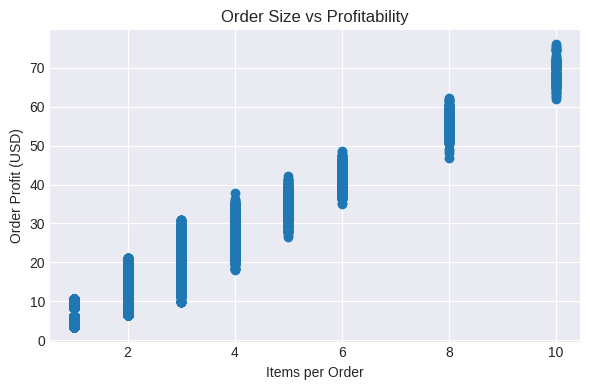

In [16]:
# Q5.3: Order size vs profitability

qty_col = "quantity" if "quantity" in items.columns else None
items_q5 = items.with_columns([
    (pl.col(qty_col) if qty_col in items.columns else pl.lit(1)).cast(pl.Int64).alias("qty")
])


prod_margin_raw = (
    products
    .join(sku_costs, on="sku", how="left")
    .with_columns([
        pl.col("price").cast(pl.Int64).alias("price_cents"),
        pl.col("unit_cost_cents").fill_null(0).cast(pl.Float64),
        ((pl.col("price").cast(pl.Int64) / 100.0)).alias("price_usd"),
        (((pl.col("price").cast(pl.Int64) - pl.col("unit_cost_cents")) / 100.0)).alias("unit_margin_usd")
    ])
    .select(["sku", "price_usd", "unit_margin_usd"])
)

items_enriched = (
    items_q5
    .join(prod_margin_raw, on="sku", how="left")
    .with_columns([
        (pl.col("unit_margin_usd").fill_null(0) * pl.col("qty")).alias("item_profit_usd"),
        (pl.col("price_usd").fill_null(0) * pl.col("qty")).alias("item_gross_usd")
    ])
)

order_level = (
    items_enriched
    .group_by("order_id")
    .agg([
        pl.sum("item_profit_usd").alias("order_profit_usd"),
        pl.sum("item_gross_usd").alias("order_gross_usd"),
        pl.sum("qty").alias("item_count")
    ])
)

order_size_profitability = (
    order_level
    .join(
        orders.select(["id", "store_id", "customer", "ordered_at", "order_total"]).rename({"id": "order_id"}),
        on="order_id",
        how="left"
    )
    .join(stores.select(["id", "name"]).rename({"id": "store_id", "name": "store_name"}), on="store_id", how="left") # Join with stores to get store_name
    .join(customers.select(["id", "name"]).rename({"id": "customer", "name": "customer_name"}), on="customer", how="left") # Join with customers to get customer_name
    .with_columns(
        (pl.col("order_total") / 100.0).alias("order_total_usd")
    )
    .select(["order_id", "store_name", "customer_name", "ordered_at", "item_count",
             "order_profit_usd", "order_gross_usd", "order_total_usd"])
)

print(order_size_profitability.head(10))

plt.figure(figsize=(6, 4))
plt.scatter(order_size_profitability["item_count"], order_size_profitability["order_profit_usd"])
plt.xlabel("Items per Order")
plt.ylabel("Order Profit (USD)")
plt.title("Order Size vs Profitability")
plt.tight_layout()
plt.show()

shape: (2, 5)
┌──────────────┬────────────┬─────────────┬──────────┬───────────────────┐
│ store_name   ┆ profit_usd ┆ revenue_usd ┆ n_orders ┆ profit_margin_pct │
│ ---          ┆ ---        ┆ ---         ┆ ---      ┆ ---               │
│ str          ┆ f64        ┆ f64         ┆ u32      ┆ f64               │
╞══════════════╪════════════╪═════════════╪══════════╪═══════════════════╡
│ Brooklyn     ┆ 174849.09  ┆ 229216.36   ┆ 22276    ┆ 0.762812          │
│ Philadelphia ┆ 323580.6   ┆ 432155.65   ┆ 40492    ┆ 0.748759          │
└──────────────┴────────────┴─────────────┴──────────┴───────────────────┘


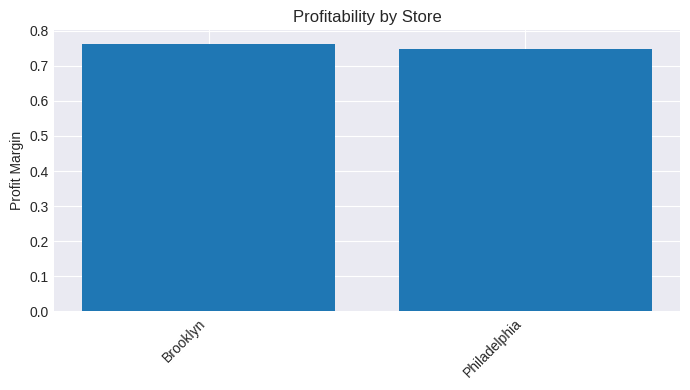

In [17]:
# Q5.4: Profitability by store
store_profitability = (
    order_size_profitability
    .join(stores.select(["id", "name"]), left_on="store_name", right_on="name", how="left")
    .group_by("store_name")
    .agg([
        pl.sum("order_profit_usd").alias("profit_usd"),
        pl.sum("order_total_usd").alias("revenue_usd"),
        pl.len().alias("n_orders")
    ])
    .with_columns([
        pl.when(pl.col("revenue_usd") > 0)
          .then(pl.col("profit_usd") / pl.col("revenue_usd"))
          .otherwise(None)
          .alias("profit_margin_pct")
    ])
    .sort("profit_margin_pct", descending=True)
)

print(store_profitability)

# Optional bar chart (comment out if not plotting here)
plt.figure(figsize=(7, 4))
plt.bar(store_profitability["store_name"], store_profitability["profit_margin_pct"])
plt.ylabel("Profit Margin")
plt.title("Profitability by Store")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Question 6: Business Optimization Recommendations

Based on your analysis, provide three specific, data-driven recommendations to improve business performance. Support each recommendation with relevant metrics and visualizations.

 Recommendation 1:

Prioritize high-margin products in marketing / promotions:

The gross margin analysis shows that certain products amongst the selection (e.g. Nutellaphone Who Dis?) outperform lower margin items significantly. This suggests an emphasis on high products could improve profitability as a whole without needing to acquire additional customers. If addtionall emphasis is put upon promoting top margin items (through bundling or marketing campaigns) Jaffle Shop can increase average oder value while maintaining profitability.

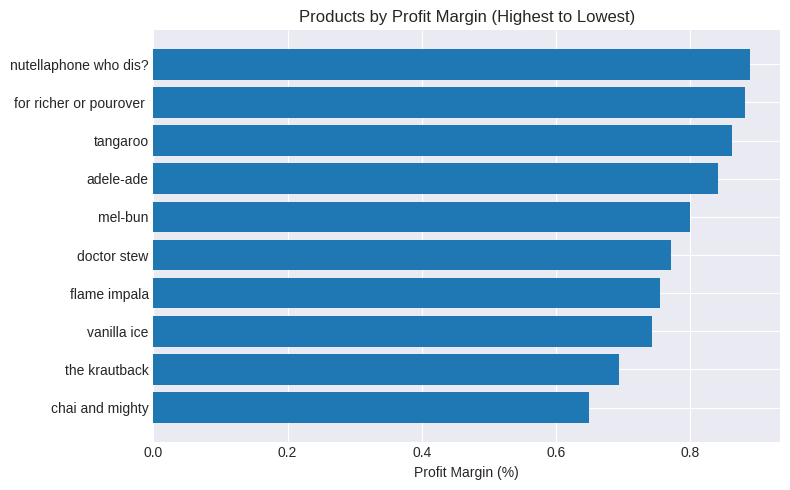

In [18]:

# Visualization of top products by profit margin
top_margin_products_chart = (
    product_margins
    .select(["name", "margin_pct"])
    .sort("margin_pct", descending=True)
)

plt.figure(figsize=(8, 5))
plt.barh(top_margin_products_chart["name"], top_margin_products_chart["margin_pct"])
plt.xlabel("Profit Margin (%)")
plt.title("Products by Profit Margin (Highest to Lowest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Recommendation 2: Consider local tax rate as a key factor in the decision-making process of expanding stores.
The store performance (revenue per day) difference between Philadelphia and Brooklyn is $20,392,937.00. This suggests stores at lower tax rate areas has better daily performance than those at higher tax rate areas.

As Jaffle Shop expands its business into Chicago, San Francisco, New Orleans, and Los Angeles, keep in mind to focus on lower tax rate areas such as New Orleans - which has the same tax rate as the high performing store in Brooklyn.

Relationship between tax rate and store performance:
shape: (6, 5)
┌───────────────┬──────────┬───────────────┬──────────────────────┬─────────────────┐
│ name          ┆ tax_rate ┆ total_revenue ┆ total_operating_days ┆ revenue_per_day │
│ ---           ┆ ---      ┆ ---           ┆ ---                  ┆ ---             │
│ str           ┆ f64      ┆ i64           ┆ i64                  ┆ f64             │
╞═══════════════╪══════════╪═══════════════╪══════════════════════╪═════════════════╡
│ Philadelphia  ┆ 0.06     ┆ 43215565      ┆ 364                  ┆ 118398.808219   │
│ Brooklyn      ┆ 0.04     ┆ 22822628      ┆ 172                  ┆ 131922.705202   │
│ Chicago       ┆ 0.0625   ┆ null          ┆ null                 ┆ null            │
│ San Francisco ┆ 0.075    ┆ null          ┆ null                 ┆ null            │
│ New Orleans   ┆ 0.04     ┆ null          ┆ null                 ┆ null            │
│ Los Angeles   ┆ 0.08     ┆ null          ┆ null                 ┆ null 

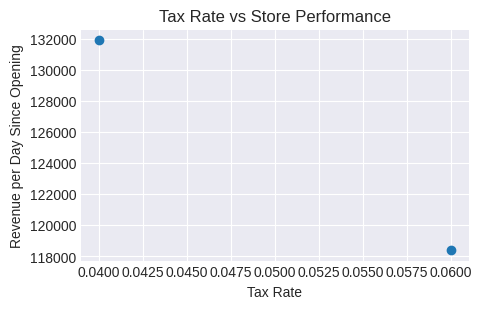

Daily revenue difference between Philadelphia and Brooklyn: $-13,523.90


In [19]:
# Supporting analysis for Recommendation 2

# Tax rates vs store performance
tax_rate_performance = stores.select(["name", "tax_rate"]).join(revenue_per_day_by_store, on="name", how="left")
print("Relationship between tax rate and store performance:")
print(tax_rate_performance)

plt.figure(figsize=(5, 3))
plt.scatter(tax_rate_performance["tax_rate"], tax_rate_performance["revenue_per_day"])
plt.xlabel("Tax Rate")
plt.ylabel("Revenue per Day Since Opening")
plt.title("Tax Rate vs Store Performance")
plt.show()

# Daily revenue difference between the two stores
philadelphia_revenue_per_day = revenue_per_day_by_store.filter(pl.col("name") == "Philadelphia").select("revenue_per_day")[0,0]
brooklyn_revenue_per_day = revenue_per_day_by_store.filter(pl.col("name") == "Brooklyn").select("revenue_per_day")[0,0]
revenue_difference_per_day = philadelphia_revenue_per_day - brooklyn_revenue_per_day
print(f"Daily revenue difference between Philadelphia and Brooklyn: ${revenue_difference_per_day:,.2f}")


### Recommendation 3:
[Strengthen Customer Loyalty and Retention through discounts, promotion codes or loyalty rewards programs ]

Top 10 Revenue Customers:
shape: (10, 2)
┌──────────────────────┬───────────────┐
│ name                 ┆ total_revenue │
│ ---                  ┆ ---           │
│ str                  ┆ i64           │
╞══════════════════════╪═══════════════╡
│ David Leonard        ┆ 262647        │
│ Jesse Moore          ┆ 259037        │
│ Diane Davis          ┆ 258515        │
│ Holly Johnson        ┆ 252703        │
│ Gregory Hayes        ┆ 249821        │
│ Julie Robinson       ┆ 247510        │
│ Christopher Robinson ┆ 246325        │
│ Douglas Burgess      ┆ 244102        │
│ Jacob Brown          ┆ 239641        │
│ Jenny Harrell        ┆ 237098        │
└──────────────────────┴───────────────┘


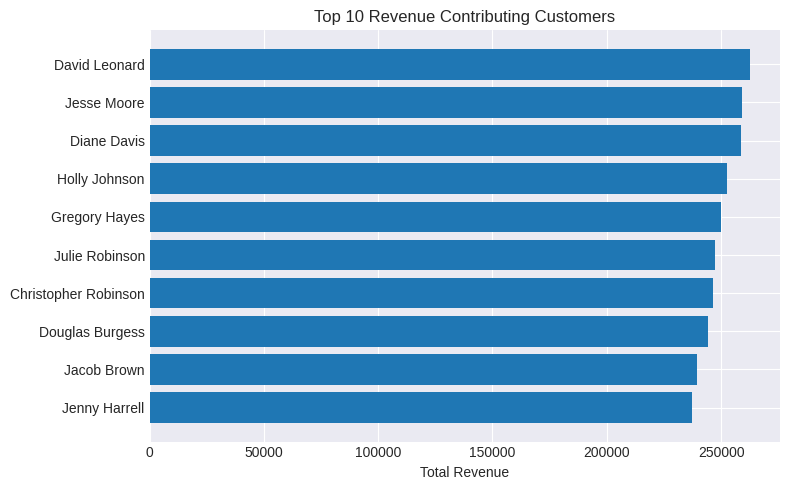

Repeat Customer Rate: 98.9%


In [20]:
# Supporting analysis for Recommendation 3

# Top revenue customers
top_revenue_customers = (
    orders
    .group_by("customer")
    .agg(pl.sum("order_total").alias("total_revenue"))
    .sort("total_revenue", descending=True)
    .head(10)
    .join(customers.select(["id", "name"]), left_on="customer", right_on="id") # Join with customers to get names
    .select(["name", "total_revenue"]) # Select name and total_revenue
    .sort("total_revenue", descending=True) # Sort again by total_revenue
)

print("Top 10 Revenue Customers:")
print(top_revenue_customers)

# Plot top 10 customers
plt.figure(figsize=(8, 5))
plt.barh(top_revenue_customers["name"], top_revenue_customers["total_revenue"]) # Use name for plotting
plt.xlabel("Total Revenue")
plt.title("Top 10 Revenue Contributing Customers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Repeat customer analysis
repeat_customer_analysis = (
    orders.group_by("customer")
    .agg(pl.count("id").alias("num_orders"))
    .with_columns([
        (pl.col("num_orders") > 1).alias("is_repeat_customer")
    ])
)

repeat_rate = repeat_customer_analysis["is_repeat_customer"].mean()
print(f"Repeat Customer Rate: {repeat_rate*100:.1f}%")

Top 10 Revenue Customers:
shape: (10, 2)
┌──────────────────────┬───────────────┐
│ name                 ┆ total_revenue │
│ ---                  ┆ ---           │
│ str                  ┆ i64           │
╞══════════════════════╪═══════════════╡
│ David Leonard        ┆ 262647        │
│ Jesse Moore          ┆ 259037        │
│ Diane Davis          ┆ 258515        │
│ Holly Johnson        ┆ 252703        │
│ Gregory Hayes        ┆ 249821        │
│ Julie Robinson       ┆ 247510        │
│ Christopher Robinson ┆ 246325        │
│ Douglas Burgess      ┆ 244102        │
│ Jacob Brown          ┆ 239641        │
│ Jenny Harrell        ┆ 237098        │
└──────────────────────┴───────────────┘


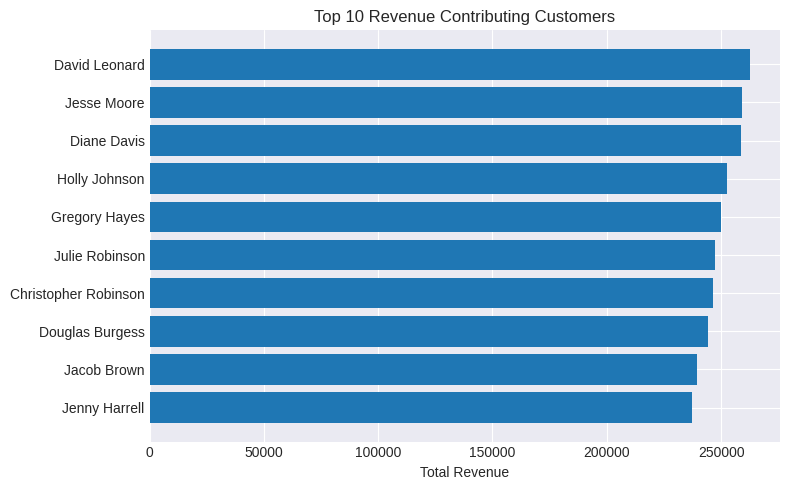

Repeat Customer Rate: 98.9%


In [21]:
# Supporting analysis for Recommendation 3

# Top revenue customers
top_revenue_customers = (
    orders.group_by("customer")
    .agg(pl.sum("order_total").alias("total_revenue"))
    .sort("total_revenue", descending=True)
    .head(10)
    .join(customers.select(["id", "name"]), left_on="customer", right_on="id") # Join with customers to get names
    .select(["name", "total_revenue"]) # Select name and total_revenue
    .sort("total_revenue", descending=True) # Sort again by total_revenue
)

print("Top 10 Revenue Customers:")
print(top_revenue_customers)

# Plot top 10 customers
plt.figure(figsize=(8, 5))
plt.barh(top_revenue_customers["name"], top_revenue_customers["total_revenue"]) # Use name for plotting
plt.xlabel("Total Revenue")
plt.title("Top 10 Revenue Contributing Customers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Repeat customer analysis
repeat_customer_analysis = (
    orders.group_by("customer")
    .agg(pl.count("id").alias("num_orders"))
    .with_columns([
        (pl.col("num_orders") > 1).alias("is_repeat_customer")
    ])
)

repeat_rate = repeat_customer_analysis["is_repeat_customer"].mean()
print(f"Repeat Customer Rate: {repeat_rate*100:.1f}%")

## Executive Summary


Jaffle Shop’s financial and operational data provides valuable insights into its current performance and growth opportunities. Across its two active locations, the company has generated $66 million in total revenue, with Philadelphia contributing 65% of sales and Brooklyn driving the remaining 35%. While both locations are profitable, significant differences in revenue per day, customer behavior, and product margins reveal clear paths for business optimization.

Key metrics such as repeat customer rates, profit margins on core menu items, and detailed revenue patterns by store, time, and product inform a foundation for continued growth and strategic optimization. Focused attention on site expansion, implement customer loyalty programs and operational efficiency will be key drivers for future value creation.

### Key Findings:
1. Strong Revenue and Customer Loyalty

Total revenue stands at over $66 million, with Philadelphia delivering about 65% of sales and rest in Brooklyn .

Most of the  customers are repeat customers (98.9% recurring) which shows that Jaffle Shop has a strong loyal customer base.

Just the top 10 customers contribute over $2.5 million, strong loyal customer base/engagement.

2. Store Performance

Brooklyn performs better than Philadelphia in revenue per day. Brooklyn generates  about 131,923 per day over 172 days, However, Philadelphia generates 118,399 over 364 days, suggesting stronger sales intensity in Brooklyn.

Revenue trends by store, by month, and by day of week. We notice that revenue is consistent throughtout the weekdays except the weekend where we notice a dip. This maybe due to local market characteristics and customer behavior patterns.

3. High Product Margins and Profitability

Gross margins on main products are exceptional.Top products consistently show unit margins above 0.75 (75%) and some exceeding 85%. Beverages have a ~65-88% margin while jaffles have ~70-89%, but beverages are more consistent and on average have a higher margin which could be leveraged to drive growth.

Beverages generally have higher margin percentages, but several jaffle items are also highly profitable.

Both Brooklyn and Philadelphia maintain profit margins above 74% which indicates efficient operations in the stores.



### Strategic Recommendations:
1. Use the company's data and  KPI's to prioritize locations for future openings, focusing first on markets with demographic and demand profiles which are similar to Brooklyn and Philadelphia.

2. Analyse revenue by day and monthly trends to identify slower sale periods. Use targeted promotions, limited-time offers, or local partnerships on those low volume days to smooth revenue variability and to drive incremental growth.

3. Start Customer Loyalty Initiatives. since customer's at Jaffle are mainly repeat customers with a rate near 99%, invest  in loyalty programs, personalized offers, and targeted communications to maximize lifetime value and gather richer customer insights.